In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow
from tensorflow import TensorSpec, float32, int32
from tensorflow import keras, data
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.data.experimental import load
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
# load helper funcs
import sys, os
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'src'))
import run_multiclass_models_AWS as multiclass_funcs
import helper_funcs as my_funcs

In [4]:
# create directory of files
directory = '/Users/pault/Desktop/github/CampsitePredict/data/sat_images/'
destination = '/Users/pault/Desktop/github/CampsitePredict/data/symlink_data/'
dest_dir_name = 'wild_est_informal_un_aug'
class_dirs = ['Wild Camping', 'Established Campground', 'Informal Campsite']

In [5]:
# filedict = my_funcs.make_symlinks_only_unaugmented(directory, destination, dest_dir_name, class_dirs)

In [6]:
# zip them for AWS

In [7]:
batch_size = 32
img_size = 256
img_height = 256
img_width = 256
final_dense = 256

In [8]:
directory = '/Users/pault/Desktop/github/CampsitePredict/data/symlink_data/wild_est_informal_un_aug'

In [9]:
# X_train = image_dataset_from_directory(
#     directory, labels='inferred', class_names=None, label_mode='categorical',
#     color_mode='rgb', batch_size=batch_size, image_size=(img_size, img_size), shuffle=True, seed=42,
#     validation_split=0.25, subset='training', interpolation='bilinear', follow_links=True
#     )

In [10]:
10273-7705

2568

In [11]:
X_train, X_test, X_holdout = multiclass_funcs.load_data_from_dir(directory, batch_size, img_size, 2568)

Found 10273 files belonging to 3 classes.
Using 7705 files for training.
Found 10273 files belonging to 3 classes.
Using 2568 files for validation.
 holdout size: 513, test size: 2055


In [12]:
X_train.class_names

['Established Campground', 'Informal Campsite', 'Wild Camping']

In [13]:
class_names, class_weights = multiclass_funcs.get_class_weights(X_train)

In [14]:
class_names

['Established Campground', 'Informal Campsite', 'Wild Camping']

In [15]:
class_weights

{'Established Campground': 2613.0,
 'Informal Campsite': 1816.0,
 'Wild Camping': 3276.0}

In [16]:
class_names = X_train.class_names
labels = np.concatenate([y for x, y in X_train], axis=0)
weights = list(np.sum(labels, axis=0))
class_weights = {}
for i, weight in enumerate(weights):
    class_weights[i] = weight

In [17]:
class_weights

{0: 2613.0, 1: 1816.0, 2: 3276.0}

In [18]:
num_classes = len(X_train.class_names)
epochs = 10 # number of passes through the entire train dataset before weights "final"
AUTOTUNE = data.experimental.AUTOTUNE
nb_filters = 32    # number of convolutional filters to use - want 1 for each "feature" you think exists in images if more, more parameters
pool_size = (2, 2)  # pooling decreases image size, reduces computation, adds translational invariance
kernel_size = (2, 2)  # convolutional kernel size, slides over image to learn features

In [19]:
X_train, X_test = multiclass_funcs.prep_data(X_train, X_test, batch_size=batch_size)

In [20]:
model = multiclass_funcs.build_model(num_classes, nb_filters, kernel_size, pool_size, img_height, img_width, final_dense)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      8

In [22]:
my_callbacks = [
    callbacks.EarlyStopping(patience=5),
#     callbacks.ModelCheckpoint(
#                         filepath='../data/tensorboard_models/model.{epoch:02d}-{val_loss:.2f}.h5', 
#                         monitor='val_loss', 
#                         verbose=0, 
#                         save_best_only=False,
#                         save_weights_only=False, 
#                         mode='auto', 
#                         save_freq='epoch', 
#                         options=None),
    callbacks.TensorBoard(log_dir='./logs',
                          histogram_freq=2,
                          write_graph=True,
                          write_images=True),
]

In [23]:
# %load_ext tensorboard
# %tensorboard --logdir logs

In [ ]:
history = model.fit(
            X_train,
            validation_data = X_test,
            epochs = epochs,
            class_weight = class_weights,
            verbose = 2
            # callbacks=my_callbacks
)

Epoch 1/10


In [22]:
history = model.fit(
            X_train,
            validation_data = X_test,
            epochs = epochs,
            class_weights = class_weights,
            verbose = 2
            # callbacks=my_callbacks
)

Epoch 1/10
241/241 - 281s - loss: 1.1015 - accuracy: 0.3391 - val_loss: 1.0986 - val_accuracy: 0.3197
Epoch 2/10
241/241 - 340s - loss: 1.0990 - accuracy: 0.3403 - val_loss: 1.0986 - val_accuracy: 0.3197
Epoch 3/10


KeyboardInterrupt: 

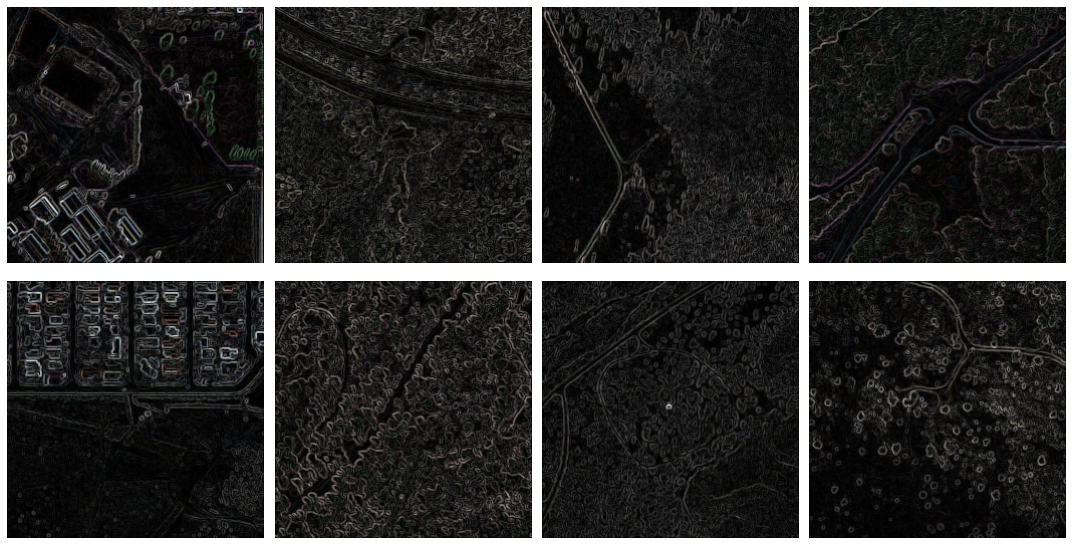

In [ ]:
# check model
num_samples = 10
figsize = (15,8)
my_funcs.plot_example_imgs(X_test, class_names, figsize, num_samples);
# plt.savefig('../images/example_imgs.png') 

In [ ]:
y, predictions, y_pred, y_pred_bin, fpr_keras, tpr_keras, thresholds_keras, auc_keras = my_funcs.run_model(model, X_test)

173/173 - 2s


In [ ]:
print(classification_report(y, y_pred_bin))

              precision    recall  f1-score   support

           0       0.68      0.73      0.71      2382
           1       0.78      0.74      0.76      3130

    accuracy                           0.74      5512
   macro avg       0.73      0.74      0.73      5512
weighted avg       0.74      0.74      0.74      5512



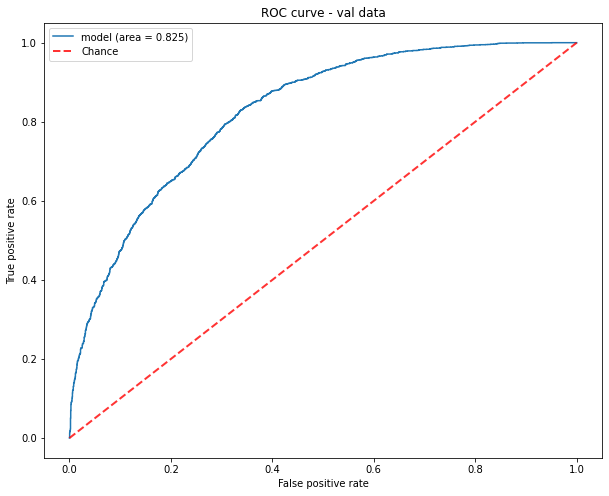

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 8))
ax = my_funcs.get_ROC_plot(ax, fpr_keras, tpr_keras, auc_keras, 'ROC curve - val data')

In [ ]:
confmat = my_funcs.compute_confusion_matrix(y, y_pred_bin)
confmat

array([[0.68423122, 0.21623442],
       [0.31576878, 0.78376558]])

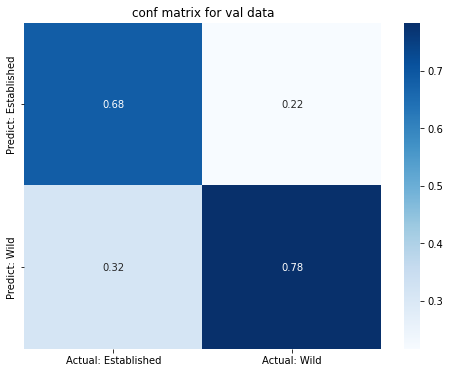

In [ ]:
x_labels = ['Predict: Established', 'Predict: Wild'] 
y_labels = ['Actual: Established', 'Actual: Wild']

fig, ax = plt.subplots(1, figsize = (8,6))
ax = my_funcs.plot_conf_matrix(confmat, ax, x_labels, y_labels, 'conf matrix for val data')

In [ ]:
y_predictions_df = my_funcs.get_imgs_into_df(X_test, y, y_pred_bin)
wrong_imgs = y_predictions_df[y_predictions_df['predict'] != y_predictions_df['actual']]

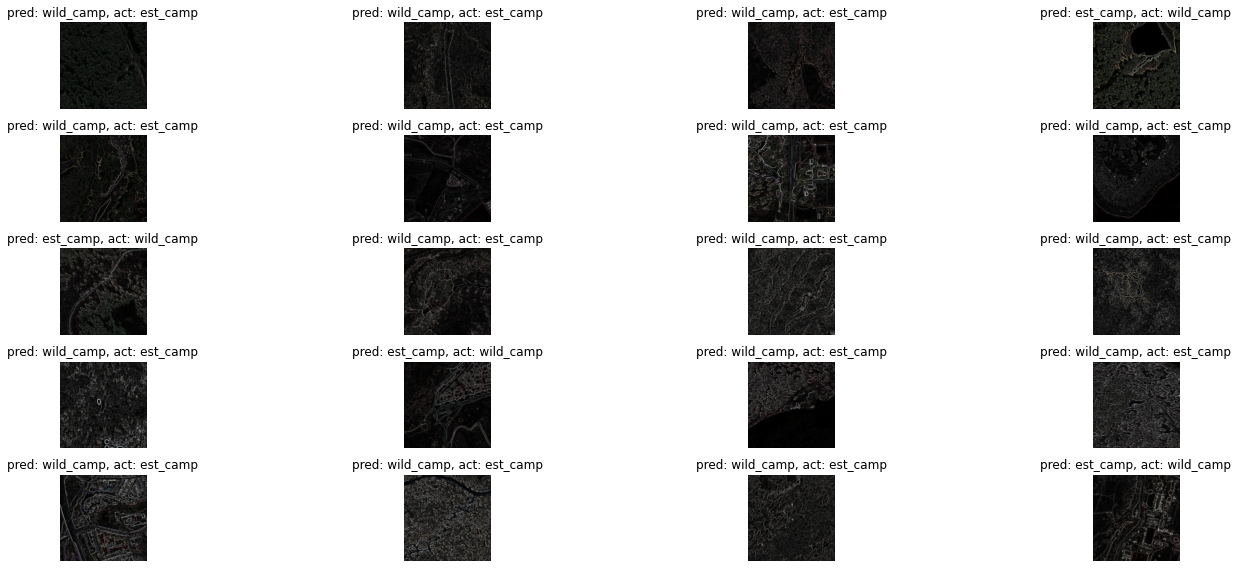

In [ ]:
num_samples = 20
figsize = (20,8)
fig, axs = my_funcs.plot_wrong_imgs(wrong_imgs, figsize, num_samples)